In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import offsetbox
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris, make_blobs, make_circles, fetch_lfw_people, make_s_curve
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.manifold import Isomap
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Clustering

## K-Means

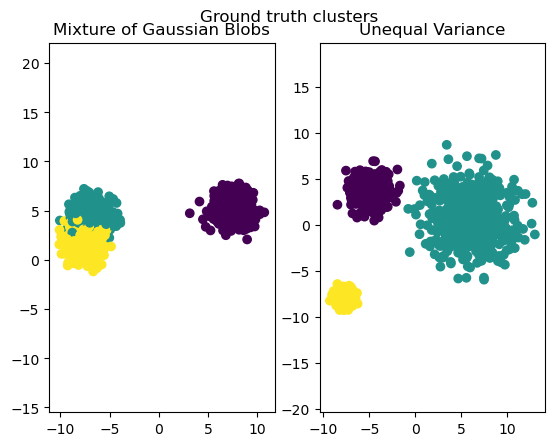

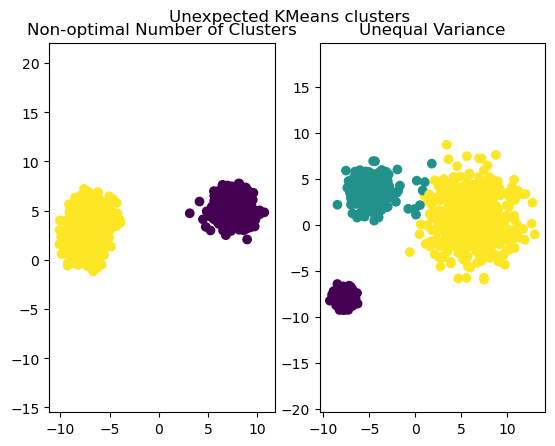

In [2]:
n_samples = 1500

X, y = make_blobs(n_samples=n_samples, cluster_std = 1.)
X_varied, y_varied = make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5],)  # Unequal variance


fig, axs = plt.subplots(nrows=1, ncols=2, )

axs[0].scatter(X[:, 0], X[:, 1], c=y)
axs[0].set_title("Mixture of Gaussian Blobs")
axs[0].axis('equal')

axs[1].scatter(X_varied[:, 0], X_varied[:, 1], c=y_varied)
axs[1].set_title("Unequal Variance")
axs[1].axis('equal')

plt.suptitle("Ground truth clusters").set_y(0.95)
plt.show()
common_params = {
    "n_init": 10,
    "random_state": 1337,
}

fig, axs = plt.subplots(nrows=1, ncols=2, )

y_pred = KMeans(n_clusters=2, **common_params).fit_predict(X)
axs[0].scatter(X[:, 0], X[:, 1], c=y_pred)
axs[0].set_title("Non-optimal Number of Clusters")
axs[0].axis('equal')

y_pred = KMeans(n_clusters=3, **common_params).fit_predict(X_varied)
axs[1].scatter(X_varied[:, 0], X_varied[:, 1], c=y_pred)
axs[1].set_title("Unequal Variance")
axs[1].axis('equal')


plt.suptitle("Unexpected KMeans clusters").set_y(0.95)
plt.show()

## Clustering Hiéarchique

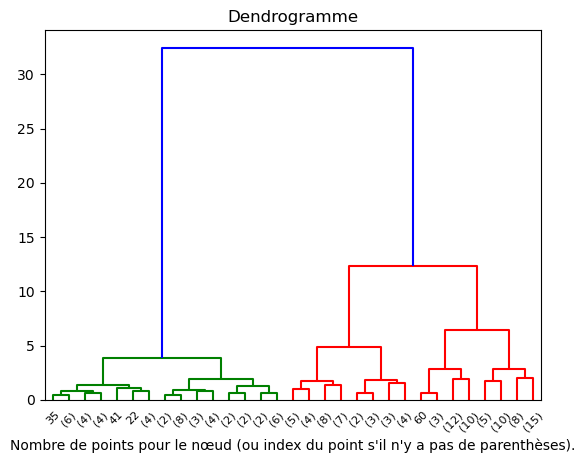

In [3]:


def plot_dendrogram(model, **kwargs):
    # Créer la matrice de similarité puis affiche le dendrogramme

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


iris = load_iris()
X = iris.data

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X)
plt.title("Dendrogramme")
# dessine les 3 grandplot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=4)
plt.xlabel("Nombre de points pour le nœud (ou index du point s'il n'y a pas de parenthèses).")
plt.show()

## DBSCAN

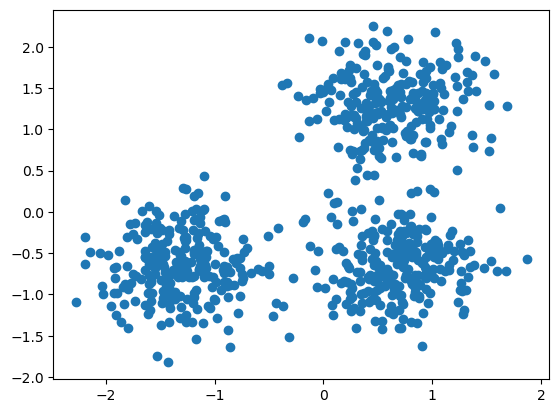

In [4]:
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(
    n_samples=750, centers=centers, cluster_std=0.4, random_state=0
)

X = StandardScaler().fit_transform(X)

plt.scatter(X[:, 0], X[:, 1])
plt.show()

Estimated number of clusters: 3
Estimated number of noise points: 18


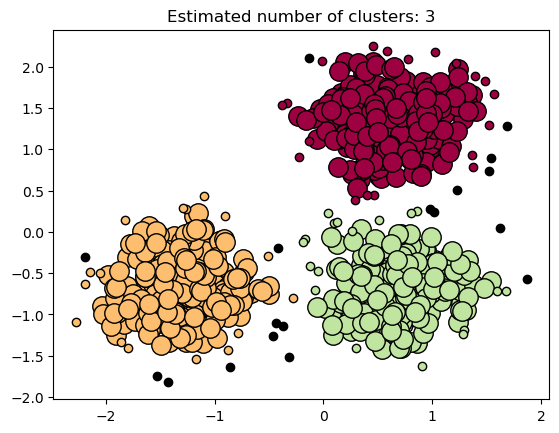

In [5]:
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

#### Plot
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

# Big dot = Core, Small dot = non-core, small and black = noise/outlier

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title(f"Estimated number of clusters: {n_clusters_}")
plt.show()

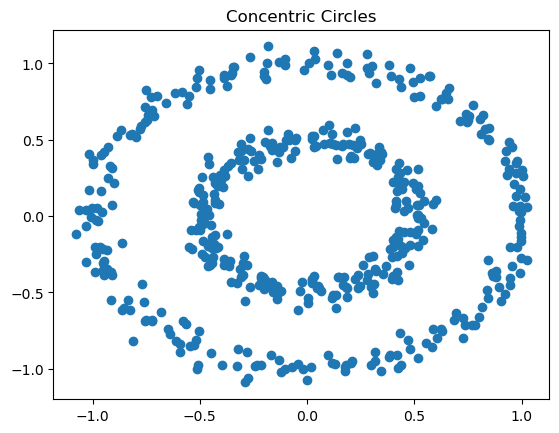

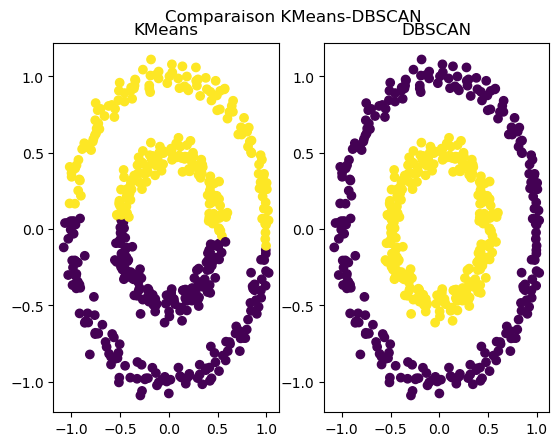

In [6]:
X, y = make_circles(n_samples=500, factor=0.5, noise=0.05)
plt.figure()
plt.scatter(X[:,0],X[:,1])
plt.title("Concentric Circles")
plt.show()


fig, axs = plt.subplots(nrows=1, ncols=2, )

y_pred = KMeans(n_clusters=2, **common_params).fit_predict(X)
axs[0].scatter(X[:, 0], X[:, 1], c=y_pred)
axs[0].set_title("KMeans")


# DBSCAN params need fiddling
db = DBSCAN(eps=0.2, min_samples=5).fit(X)
labels = db.labels_
axs[1].scatter(X[:, 0], X[:, 1], c=labels)
axs[1].set_title("DBSCAN")


plt.suptitle("Comparaison KMeans-DBSCAN").set_y(0.95)
plt.show()



# PCA et réduction de dimension

## Dans la nature, plus ou moins

https://dafx2020.mdw.ac.at/proceedings/papers/DAFx20in22_paper_22.pdf

## Nightmare Fuel

In [7]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)


Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [8]:
# Good practice for any classification pipeline
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
n_components = 150

print(
    "Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0])
)
pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True).fit(X_train)

print("Done computing PCA.")
eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("All done!")

Extracting the top 150 eigenfaces from 966 faces
Done computing PCA.
Projecting the input data on the eigenfaces orthonormal basis
All done!


In [10]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

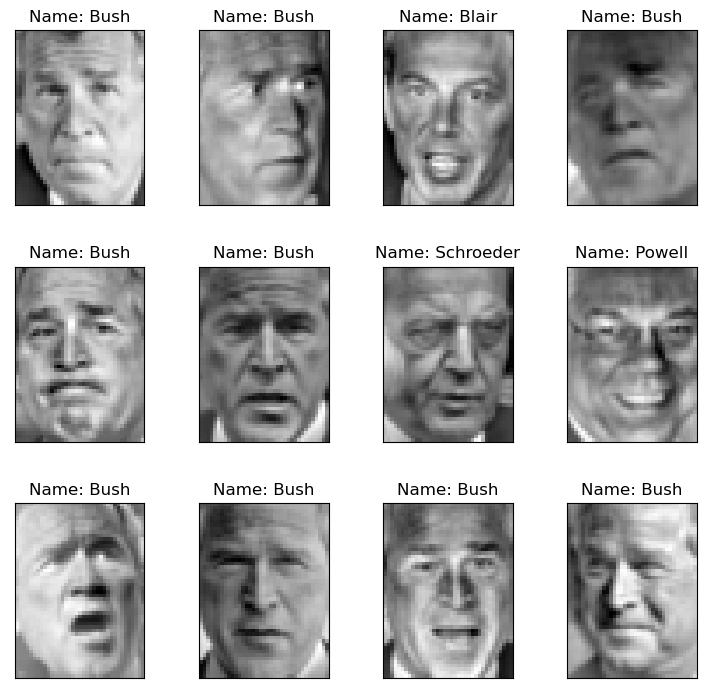

In [11]:
def title( y_test, target_names, i):
    true_name = target_names[y_test[i]].rsplit(" ", 1)[-1]
    return f"Name: {true_name}"


prediction_titles = [
    title(y_test, target_names, i) for i in range(y_test.shape[0])
]

plot_gallery(X_test, prediction_titles, h, w)

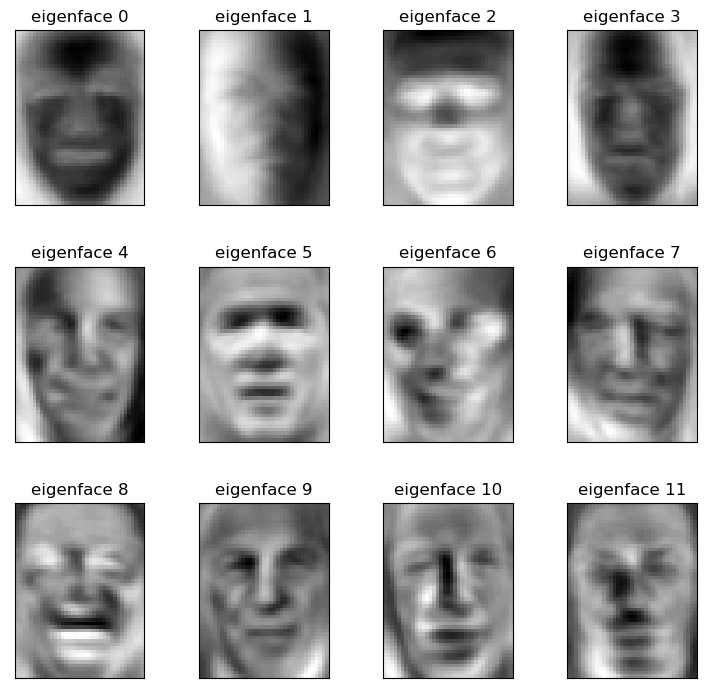

In [12]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

## ISOMap et Manifold Learning

In [13]:
n_samples = 1500
S_points, S_color = make_s_curve(n_samples, random_state=0)

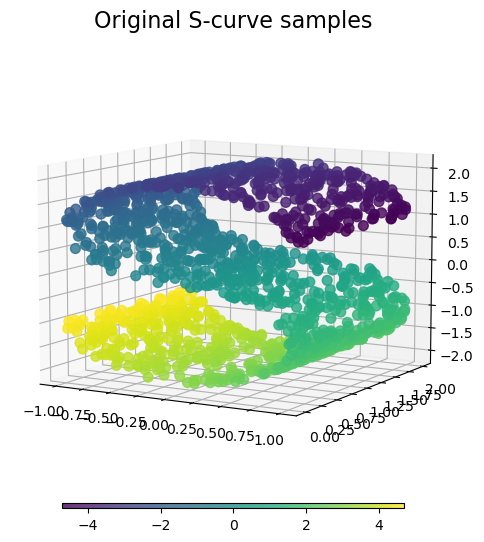

In [14]:
def plot_3d(points, points_color, title):
    x, y, z = points.T

    fig, ax = plt.subplots(
        figsize=(6, 6),
        facecolor="white",
        tight_layout=True,
        subplot_kw={"projection": "3d"},
    )
    fig.suptitle(title, size=16)
    col = ax.scatter(x, y, z, c=points_color, s=50, alpha=0.8)
    ax.view_init(azim=-60, elev=9)

    fig.colorbar(col, ax=ax, orientation="horizontal", shrink=0.6, aspect=60, pad=0.01)
    plt.show()


def plot_2d(points, points_color, title):
    fig, ax = plt.subplots(figsize=(3, 3), facecolor="white", constrained_layout=True)
    fig.suptitle(title, size=16)
    add_2d_scatter(ax, points, points_color)
    plt.show()


def add_2d_scatter(ax, points, points_color, title=None):
    x, y = points.T
    ax.scatter(x, y, c=points_color, s=50, alpha=0.8)
    ax.set_title(title)

plot_3d(S_points, S_color, "Original S-curve samples")

In [15]:
n_neighbors = 12  # neighborhood which is used to recover the locally linear structure
n_components = 2  # number of coordinates for the manifold

isomap = Isomap(n_neighbors=n_neighbors, n_components=n_components, p=1)
S_isomap = isomap.fit_transform(S_points)

pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True).fit(S_points)
S_pca = pca.transform(S_points)
print("All done!")


All done!


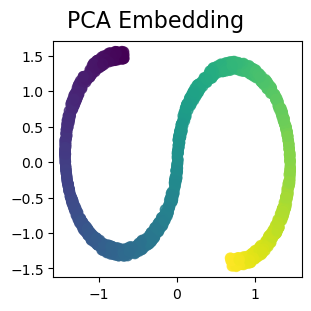

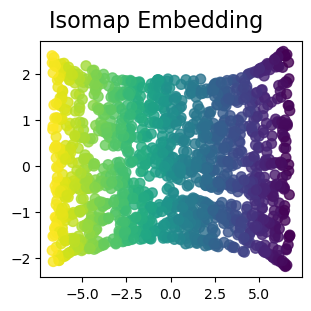

In [16]:
plot_2d(S_pca, S_color, "PCA Embedding")
plot_2d(S_isomap, S_color, "Isomap Embedding")

## ISOMAP en haute dimension

In [17]:
def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)


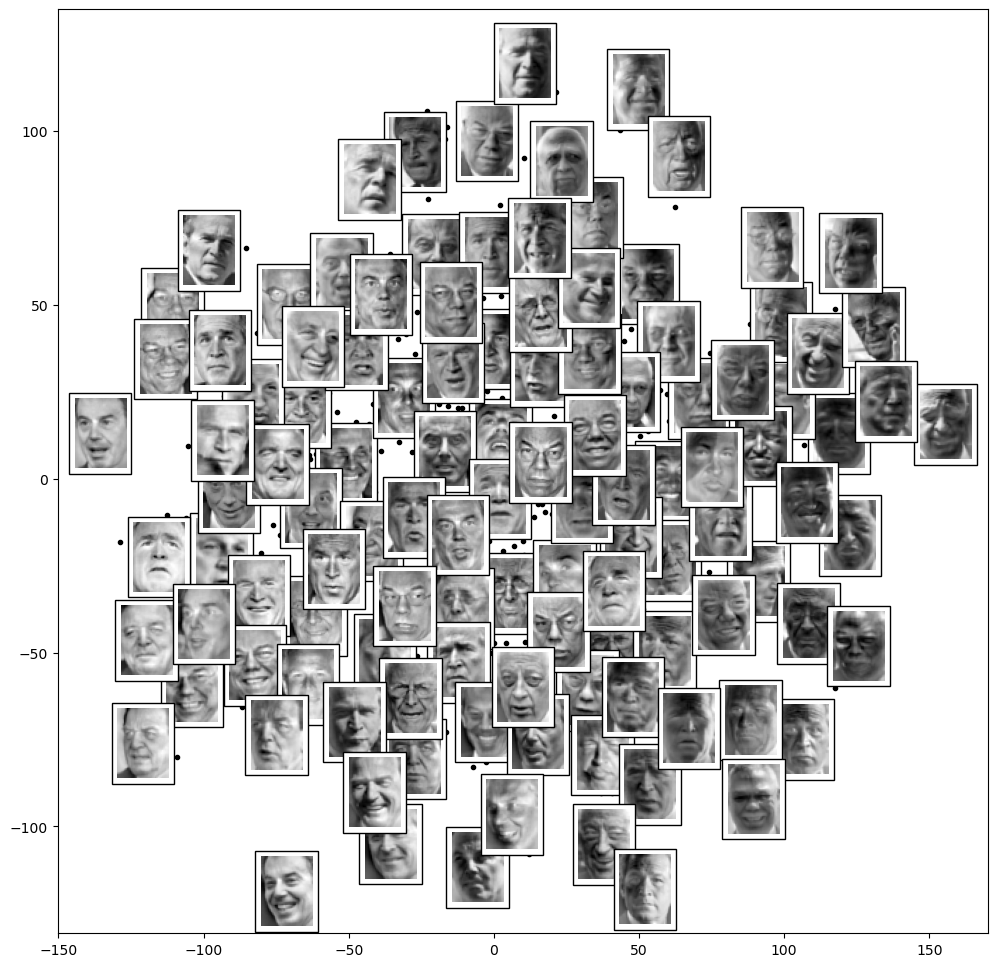

In [18]:
fig, ax = plt.subplots(figsize=(12, 12))
# Dans ce cas, IsoMap va chercher les 5 plus proches voisins d'un point.
plot_components(X_train,
                model=Isomap(n_components=2),
                images=X_train.reshape((-1,h,w))[:, ::, ::])